# Машинное обучение и майнинг данных

## 09/03/2017 Алгоритмы кластеризации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print u'Так надо'

# Кластеризация

Cluster — сгусток, пучок (англ.) </br>
Основная задача кластерного анализа — разбиение исходного набора объектов на различающиеся между собой подмножества объектов, состоящие из близких элементов.

* Методы получения разбиений
* Иерархические методы
* Плотностные методы
* Непараметрические методы

## Алгоритм k-means

* Метод k-средних является итеративным алгоритмом разбиения множества объектов на k классов. 
* Центр масс кластера (внутрикластерное среднее по каждому признаку) Cj называется центроидом

#### Критерий

$$ L(C) = \sum_{k=1}^K\sum_{i\in C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C $$

## Алгоритм k-means
1. Выбрать $K$ начальных центроидов случайным образом  $\rightarrow \mu_k, \ k=1\dots K$
2. Для каждой точки из датасета присвоить кластер, соответствующий ближайшему центроиду
$$C_k = \{x_n : ||x_n - \mu_k|| \leq ||x_n - \mu_l|| \quad \forall l \neq k \} $$
3. Обновить центройды: 
$$\mu_k = \frac{1}{|C_k|} \sum _{x_n \in C_k} x_n$$
4. Повторять 2 и 3 до тех пор, пока изменения перестанут быть существенными 


<center><img src='images/Kmeans_animation.gif' width=500></center>

## Kак выбрать K?

* Не пользоваться обычным k-means (X-means, ik-means)
* Посмотреть на меры качества кластеризации 
* Воспользоваться эвристиками

## Elbow method (Метод локтя)

* Критерий минимизации k-means
$$ L(C) = \sum_{k=1}^K\sum_{i\in C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C $$
* Давайте возьмем всевозможные $K$, для каждого запустим алгоритм, посчитаем на результате $L(C)$ и выберем минимум!

* Ничего не выйдет... Почему?

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 


crit = []

for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    crit.append(np.sqrt(kmeans.inertia_))
    
def elbow_demo(k=2):
    
    X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 
    
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].scatter(X[:,0], X[:,1], c=kmeans.labels_)
    
    ax[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  marker='o', c="white", alpha=1, s=200)
    
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')

    for i, c in enumerate(kmeans.cluster_centers_):
        ax[0].scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
        
    ax[1].plot(range(2,8), crit, marker='s')
    
    ax[1].set_xlabel('$k$')
    ax[1].set_ylabel('$L^{(k)}(C)$')
    
    
    

## Elbow method (Метод локтя)

* Выбирают такое $k$, после которого функционал $L(C)$ уменьшается не слишком быстро
* Чуть более формально:
$$ D(k) = \frac{|L^{(k)}(C) - L^{(k+1)}(C)|}{|L^{(k-1)}(C) - L^{(k)}(C)|} \quad \text{"невелико"} $$

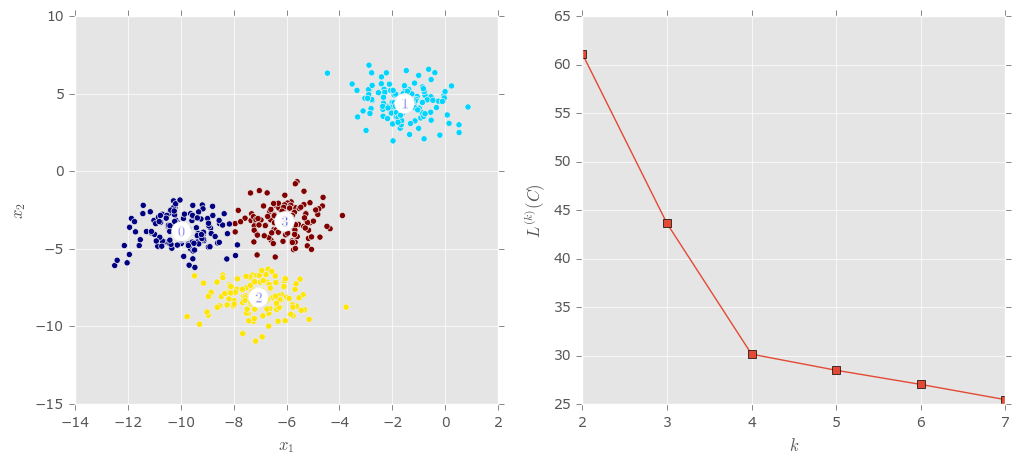

In [3]:
interact(elbow_demo, k=IntSlider(min=2,max=8,step=1,value=2))

## Важно!
* Эвристика и меры качества клатеризации носят лишь рекомендательный характер!
* Если они ничего не дают, то лучше ориентироваться на свои знания в предметной области
* Или "выжать" из полученной кластеризации максимум
    * *3 из 5 полученных кластеров интерпретируются - и то хорошо*

# Иерархическая кластеризация

#### Пример: семейства языков
<center><img src='images/languages.png'></center>

#### Пример: биология
<center><img src='images/dinosaurs.jpg'></center>

** Аггломеративные алгоритмы **
* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


** Дивизивные алгоритмы **
* начинаем с ситуации, когда все объекты составляют один кластер
* на каждом шаге разделяем один из кластеров пополам
* останавливаемся, когда получаем требуемое количество или $N$ кластеров


### Аггломеративный алгоритм

```{C}
1. function agglomerative(X, K):

2.	initialize N # number of objects
3.	initialize C = N # number of clusters
4.	initialize C_i = x_i # initial clusters
5.	while C > K:
6.		C_a = C_b = None # closest clusters
7.		min_dist = +inf # distance between closest
8.		for i in 1 .. C:
9.			for j in i + 1 .. C:
10.				dist = d(C_i, C_j) # dist. betw. clusters
11.				if dist < min_dist:
12.					min_dist = dist
13.					C_a = C_i
14.					C_b = C_j		
15.		merge(C_a, C_b)

16.		C = C - 1	
17.	return C_1, ..., C_K
```

<center><img src='images/dendro1.png'></center>

*  Как определять близкие объекты?
*  Как пересчитывать расстояние между кластерами после объединения?

# Меры близости

* Как определить похожие объекты?

* Необходимо ввести функцию расстояния (не обязательно метрику)

### Количественные признаки

$$ d(a, b) = \sum\limits_{i=1}^{D}(a_i - b_i)^2 \text{: euclidean distance} $$

$$ d(a, b) = \sum\limits_{i=1}^{D}|a_i - b_i| \text{: manhattan distance} $$

$$ d(a, b) = \frac{\langle a,b \rangle}{||a||\cdot||b||} \text{: cosine similarity} $$


### Близость на бинарных векторах

* Пусть объект описываеться набором бинарных признаков <br/>(достиг 18 лет, отслужил в армии, закончил университет, женат)
    * Иван: `(1, 0, 1, 0)`
    * Геннадий:     `(1, 1, 0, 1)`
* Расстояние Хэмминга -  Hamming distance
    * Количество (доля) несовпавших значений
    
    $$d(\text{Иван},\text{Геннадий}) = 3 $$


### Близость на множествах
* Пусть объект описываеться набором категорий, слов, тегов
    * Клиент a: {Картофель фри, биг-мак, кофе, маффин}
    * Клиент b: {Картофель фри, сырный соус, чизбургер, кофе, пирожок}
* Расстояние Жаккара - Jaccard distance:
$$d(a,b) = 1 - \frac{|a \cap b|}{|a \cup b|}$$

$$d(a,b) = 1 - \frac{2}{7} = \frac{5}{7} $$


### Расстояние на строках
* Расстояние Левенштейна<br/>
Количество вставок, замен и удалений, которое необходимо сделать, чтобы получить из строки $S_1$ строку $S_2$

\begin{equation}
 D ( i , j ) = 
 \begin{cases} 
 {\begin{array}{llcl}0,&&&i=0,\ j=0\\i,&&&j=0,\ i>0\\j,&&&i=0,\ j>0\\\min\{\\&D(i,j-1)+1,\\&D(i-1,j)+1,&&j>0,\ i>0\\&D(i-1,j-1)+{\rm {m}}(S_{1}[i],S_{2}[j])\\\}\end{array}},
 \end{cases} 
\end{equation}
где $m(a,b)$ - равно $0$, если $a = b$ и $1$ в ином случае


<center><img src='images/levinstein_dist.png' width=300></center>

## Пересчет расстояний после объединения кластеров

* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Centroid linkage
$$ d_{cent}(C_i, C_j) = \|\mu_i -\mu_j \| $$

* Ward linkage
$$ d_{ward}(C_i, C_j) = \sqrt{\frac{n_i n_j}{n_i + n_j}} \|\mu_i - \mu_j \|$$


In [4]:
X = np.array([
        [1,1],
        [2,2],
        [2, 2.5],
        [5, 2],
        [4.5, 5],
        [3, 6],
        [5, 6],
        [6, 6]
    ])

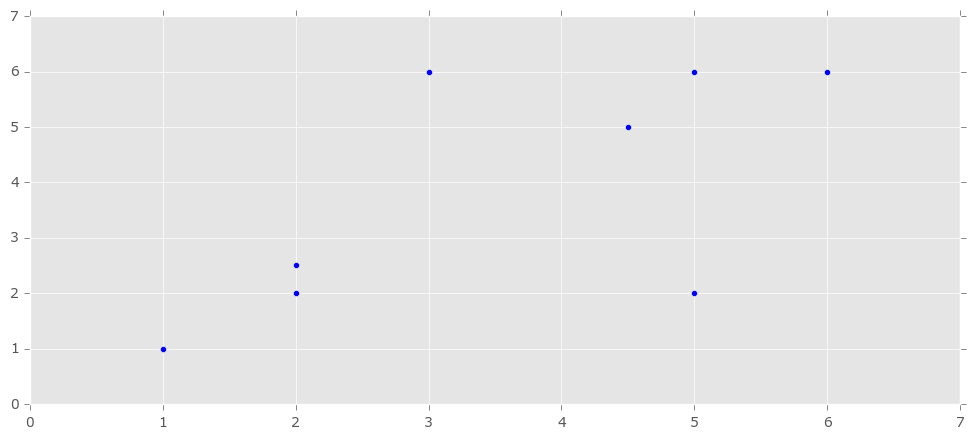

In [5]:
plt.scatter(X[:,0], X[:,1]) 

array([2, 2, 2, 3, 1, 1, 1, 1], dtype=int32)

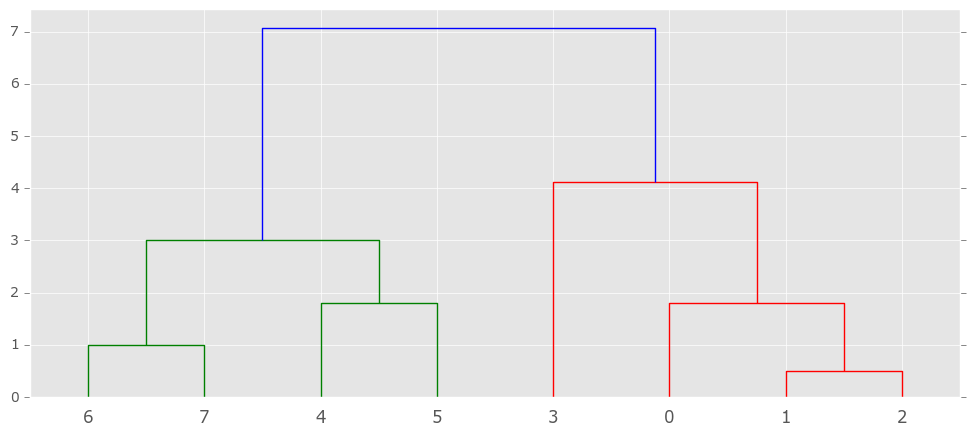

In [17]:
# А теперь сделаем это с питоном
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

Z = linkage(X, method='complete', metric='euclidean')
dend = dendrogram(Z)
y_hat = fcluster(Z, 3, criterion='maxclust')
y_hat


In [20]:
# Попробуем sklearn

from sklearn.cluster import AgglomerativeClustering

clust = AgglomerativeClustering(n_clusters=3, affinity='euclidean',
                               linkage='complete')
clust.fit(X)

y_hat = clust.labels_
y_hat

array([1, 1, 1, 2, 0, 0, 0, 0])

##  Эвристика для оценки качества дендрограммы

* **Кофенетическое расстояние** между объектами $x_i$ и $x_j$ - высота дерева, при котором эти объекты объединились.


<center><img src='images/dendro2.png' width=700></center>

### Кофенетическая корреляция

* Кофенетическая корреляция — коэффициент корреляции между массивами попарных расстояний и попарных кофенетических расстояний.

$$ \text{cophCorr} = \frac{\sum\limits_{i < j}(d(x_i, x_j) - \bar{d})(coph(x_i, x_j) - \bar{coph})}{\sqrt{\sum\limits_{i < j}(d(x_i, x_j) - \bar{d})^2 \cdot \sum\limits_{i < j}(coph(x_i, x_j) - \bar{coph})^2}} $$

При "удачно" построенном дереве эти массивы должны сильно коррелировать.

In [7]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet

def coph_demo(link='single', metric='euclidean', k=2):
    
    X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 
    
    d = pdist(X, metric=metric)
    
    Z = linkage(X, method=link, metric=metric)
    labels = fcluster(Z,  k, criterion='maxclust')
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].scatter(X[:,0], X[:,1], c=labels)
        
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')
        
    dend = dendrogram(Z, ax=ax[1], truncate_mode='lastp')   
    coph_corr, coph_dist = cophenet(Z, d)
    
    ax[1].set_title('cophCorr = %.3f' % coph_corr)
    
    

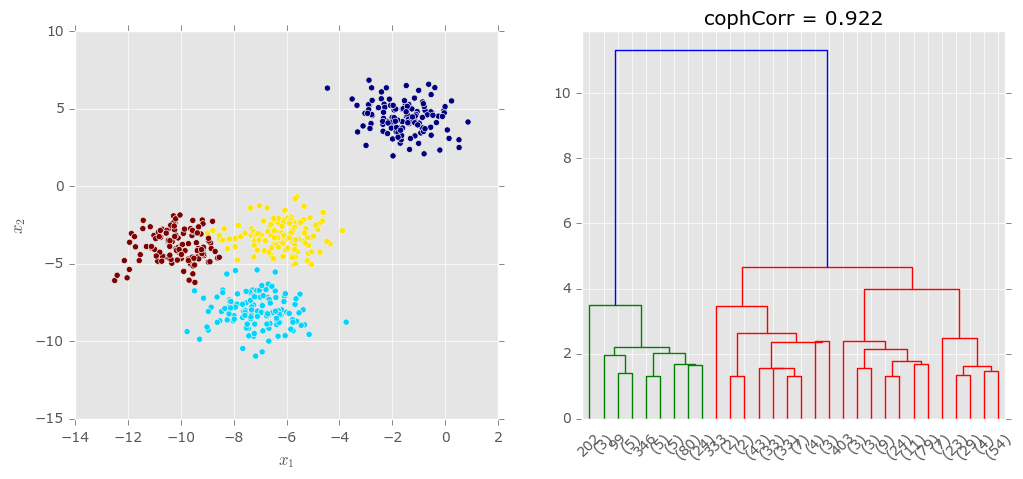

In [21]:
interact(coph_demo, k=IntSlider(min=2, max=10, step=1, value=2), link=['complete', 'single', 'average', 'centroid'], metric=['euclidean', 'cityblock'])

## Итог
#### Преимущества
*  Несферические кластеры
*  Разнообразие критериев
*  Любые K из коробки
*  Наглядность с дендрограммой

#### Недостатки
*  Требует много ресурсов

# Алгоритмы, основанные на плотности
<center><img src='images/density.jpg'></center>


## Хотелось бы...

* Получить кластеры высокой плотности, разделеные участками низкой плотности

<center><img src='images/dbscan.png'></center>



## Геоданные

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e"><img src='images/dbscan1.png' width=600></th>
    <th class="tg-031e"><img src='images/dbscan2.png' width=600></th>
  </tr>
</table>

## Основная идея

* Для каждой точки кластера её окрестность заданного радиуса должна содержать не менее некоторого числа точек `min_pts`. 
* $N_\epsilon(x_i) \geq \texttt{min_pts}$, где $N_\epsilon(x_i)$ — множество точек, расположенных не далее, чем на расстоянии $\epsilon$ от $x_i$ (плотность).


#### Типы объектов
* Объект $x_i$ называется **сore-объектом**, если $N_\epsilon(x_i) \geq \texttt{min_pts}$
* Объект $x_i$ называется **граничным объектом**, если $N_\epsilon(x_i) < \texttt{min_pts}$, но $\exists x_j : d(x_i, x_j) \leq \epsilon$ и $x_j$ - core-объект
* Объект $x_i$ называется **шумовым**, если он не является ни граничным ни core объектом

<center><img src='images/points.png' width=500></center>

## Алгоритм DBSCAN

```{C}
1.function dbscan(X, eps, min_pts):
2.	initialize NV = X # not visited objects	
3.	for x in NV:
4.		remove(NV, x) # mark as visited
5.		nbr = neighbours(x, eps) # set of neighbours
6.		if nbr.size < min_pts:
7.			mark_as_noise(x)
8.		else:
9.			C = new_cluster() 
10.			expand_cluster(x, nbr, C, eps, min_pts, NV)
11.			yield C
```

## Метод `expand_cluster`

```{C}
1. function expand_cluster(x, nbr, C, eps, min_pts, NV):
2.	add(x, C)
3.	for x1 in nbr:
4.		if x1 in NV: # object not visited
5.			remove(NV, x1) # mark as visited
6.			nbr1 = neighbours(x1, eps)
7.			if nbr1.size >= min_pts:
8.				# join sets of neighbours
9.				merge(nbr, nbr_1) 
10.		if x1 not in any cluster:
11.			add(x1, C)		
```

## Demo

[Тык](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

In [9]:
from sklearn.cluster import DBSCAN


data = np.loadtxt('flame.txt')
X_data = data[:, :2]

def dbscan_demo(eps=1, min_pts=5):
    
    dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(X_data)
    
    labels = dbscan.labels_
    
    plt.figure(figsize=(7,5))
    plt.scatter(X_data[:,0], X_data[:, 1], c=labels)
    

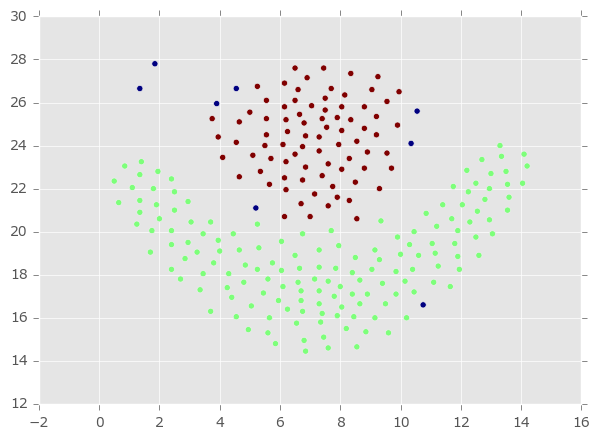

In [10]:
interact(dbscan_demo, eps=FloatSlider(min=0.1, max=10, step=0.05, value=1), min_pts=IntSlider(min=2, max=15, step=1, value=5))

## Итог

#### Преимущества
* Не требует $K$
* Кластеры произвольной формы
* Учитывает выбросы


#### Недостатки
* Не вполне детерминированный
* Не работает при различных плотностях кластеров

<center><img src='images/dbprob.png' width=500></center>

# Cluster Validity and Quality Measures


### Оценка качества кластеризации при известном groud truth

#### Доля правильно кластеризованных вешин
Пусть $\hat{\pi}$ - это полученное разбиение на кластеры, а $\pi^*$ - ground truth. Тогда доля правильно угаданных меток рассчитывается как

$$ Acc(\hat{\pi}, \pi^*) = \frac{\text{# of correctly clustered obs}}{N} \text{,}$$
где объект считается правильно кластеризован, если **хотя бы половина** объектов из того же кластера в $\hat{\pi}$ относится к некоторому кластеру в $\pi^*$

#### Adjusted Rand Index

$$ \text{Rand}(\hat{\pi},\pi^*) = \frac{a + d}{a + b + c + d} \text{,}$$
где 
* $a$ количество пар объектов, находящихся в одинаковых кластерах в $\hat{\pi}$ и
$\pi^*$, 
* $b$ ($c$) количество пар объектов в одном и том же кластере в  $\hat{\pi}$ ($\pi^*$), но в разных в  $\pi^*$ ($\hat{\pi}$)
* $d$ количество пар объектов в разных кластерах в $\hat{\pi}$ и $\pi^*$

Adjusted Rand Index - корректировка Rand index:

$$\text{ARI}(\hat{\pi},\pi^*)   = \frac{\text{Rand}(\hat{\pi},\pi^*) - \text{Expected}}{\text{Max} - \text{Expected}}$$

Так же есть **[Normalized Mutual Information](http://en.wikipedia.org/wiki/Mutual_information)**, но результаты этой метрики схожи с ARI

### Критерий Silhouette

Пусть дана кластеризация в $K$ кластеров, и объект $i$ попал в $C_k$

* $a(i)$ -- среднее расстояние от $i$ объекта до объектов из $C_k$
* $b(i) = min_{j \neq k} b_j(i)$,  где $b_j(i)$ -- среднее расстояние от $i$ объекта до объектов из $C_j$
$$
silhouette(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$
Средний silhouette для всех точек из $\mathbf{X}$ является критерием качества кластеризации.

<center><img src='images/sil1.png'></center>

<center><img src='images/sil2.png'></center>

## Что есть еще?

* Различные улучшения kmeans
* Спектральные методы
* Дивизивные алгоритмы